In [21]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *

In [3]:
path = Path('data')

In [4]:
path.ls()

[PosixPath('data/data_lm.pkl'),
 PosixPath('data/chat_eng.csv'),
 PosixPath('data/clean_chat.csv'),
 PosixPath('data/models'),
 PosixPath('data/data_clas.pkl')]

In [27]:
df = pd.read_csv(str(path) +'/chat_eng.csv', names=['label', 'text'], dtype=str)
df.head(2)

,label,text
0,Messages to this chat and calls are now secure...,NaN
1,Jade,😘😘😘😘


## Data Cleaning

In [28]:
df.replace("<Media omitted>", float("NaN"), inplace=True)
df.replace(str("nan"), float("NaN"), inplace=True)
df.replace('', float("NaN"), inplace=True)

df.dropna(inplace=True)

In [29]:
import re
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

df["text"] = df["text"].apply(lambda x: remove_emoji(x))

In [30]:
df["text"] = df["text"].apply(lambda x: re.sub("^[A-Za-z]*$",'', x))
df["text"] = df["text"].apply(lambda x: re.sub('[@0-9]', '', x))

df.replace('', float("NaN"), inplace=True)
df.dropna(inplace=True)

In [32]:
df.index = range(len(df.label))

df.to_csv(str(path) +"/clean_chat.csv")

## Language Model

In [6]:
#batch size
bs=24

In [78]:
data_lm = TextList.from_csv(path, 'clean_chat.csv', cols='text').split_by_rand_pct(0.1).label_for_lm().databunch(bs=bs)
data_lm.save('data_lm.pkl')

In [7]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)
data_lm.show_batch(1)

idx,text
0,on their walk . xxmaj just finished in the man cave xxbos xxmaj filo filo 's xxunk xxmaj jack serena xxunk xxmaj sergio and xxmaj xxunk xxbos xxmaj oh nice ... xxunk days xxbos xxmaj xxunk to avoid studying xxbos xxmaj that 's alright xxbos i think i will xxunk because of the wine xxbos xxmaj too much wine xxbos xxmaj we are xxunk xxbos xxmaj me and filo xxbos


In [80]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [81]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


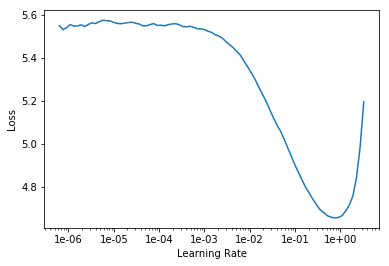

In [82]:
learn.recorder.plot()

In [83]:
learn.fit_one_cycle(1, 1e-02, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.577178,3.733948,0.262103,00:02


In [84]:
learn.save('fit_head')

In [85]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [86]:
learn.unfreeze()

In [87]:
learn.fit_one_cycle(5, 1e-02, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.430687,3.204314,0.352579,00:03
1,3.183692,3.074284,0.359722,00:03
2,2.872898,3.114635,0.365278,00:03
3,2.493025,3.276849,0.353770,00:03
4,2.118309,3.407555,0.353770,00:03


In [88]:
learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [89]:
learn.load('fine_tuned');

In [90]:
TEXT = "I liked this movie because"
N_WORDS = 15
N_SENTENCES = 2

In [93]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this movie because it was boring xxbos We 're going for a walk xxbos You get
I liked this movie because of the movie xxbos Walking to my car xxbos Do n't go there


We have to save not only the model, but also its encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [92]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels.

In [94]:
data_clas = TextList.from_csv(path, 'clean_chat.csv', vocab=data_lm.vocab)\
            .split_by_rand_pct(0.1)\
            .label_from_df(cols=1)\
            .databunch(bs=bs)
            
data_clas.save('data_clas.pkl')

In [95]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [96]:
data_clas.show_batch()

text,target
xxbos xxrep 4 xxunk,Valerio
xxbos xxrep 4 xxunk,Valerio
xxbos xxunk,Jade
xxbos xxunk,Valerio
xxbos xxunk,Jade


We can then create a model to classify those text and load the encoder we saved before.

In [103]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3)
learn.load_encoder('fine_tuned_enc')
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


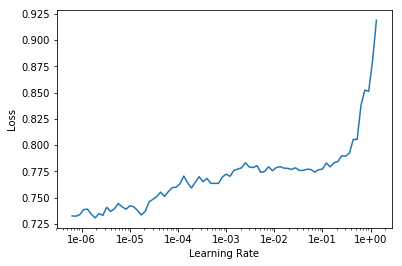

In [104]:
learn.recorder.plot()

In [106]:
learn.fit_one_cycle(1, 1e-05, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.707671,0.692797,0.513158,00:03


In [107]:
learn.save("first")

In [108]:
learn.load('first');

In [109]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.700409,0.692563,0.526316,00:03


In [110]:
learn.save('second')

In [113]:
learn.load('second');

In [114]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.696350,0.692819,0.484211,00:06
1,0.695139,0.691339,0.528947,00:06
2,0.694577,0.690563,0.528947,00:06


To increase the accuracy I need more data (it was only from last year and we haven't texted much because we moved together so the frequency of texts decreased) but still the accuracy is more than a random choice (50%)

In [129]:
pred_class,pred_idx,outputs = learn.predict("I love you")
print(pred_class, outputs)

Jade tensor([0.7462, 0.2538])


I tried the sentence "I love you" and unfortunatly Jade saw the result so now she says that this is the proof that she loves me more than I love her